# Model to classify sentiment of news articles 
- Dataset: FinancialPhraseBank
    - Fields: Sentiment (+, neutral, -), headline
- Save model, use to classify headlines found from newsapi for specific stocks
- Use sentiment scores across multiple recent articles to determine market sentiment on picked stock

In [1]:
import pandas as pd 
import numpy as np
import keras 
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
path = '../res/datasets/financial_sentiment.csv'
df = pd.read_csv(path)
df.columns = ['sentiment', 'headline']
sentiment = {
    'positive' : 2,
    'neutral' : 1,
    'negative' : 0
}
df = df.replace({'sentiment' : sentiment})
df.headline = df.headline.str.replace('[^a-zA-Z ]', '').str.lower()
print(len(df))
df.head()

4845


<ipython-input-3-08d15cb120d8>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df.headline = df.headline.str.replace('[^a-zA-Z ]', '').str.lower()


,sentiment,headline
0,1,technopolis plans to develop in stages an area...
1,0,the international electronic industry company ...
2,2,with the new production plant the company woul...
3,2,according to the company s updated strategy fo...
4,2,financing of aspocomp s growth aspocomp is agg...


In [4]:
print('negative articles: ' + str(df.sentiment.value_counts()[0]))
print('neutral articles: ' + str(df.sentiment.value_counts()[1]))
print('positive articles: ' + str(df.sentiment.value_counts()[2]))
print('len of df: ' + str(len(df)))

negative articles: 604
neutral articles: 2878
positive articles: 1363
len of df: 4845


In [5]:
df_negative = df.loc[df['sentiment'] == 0]
df = df.append([df_negative] * 3, ignore_index=True)
df_positive = df.loc[df['sentiment'] == 2]
df = df.append([df_positive], ignore_index=True)
df = df.sample(frac=1)

print('negative articles: ' + str(df.sentiment.value_counts()[0]))
print('neutral articles: ' + str(df.sentiment.value_counts()[1]))
print('positive articles: ' + str(df.sentiment.value_counts()[2]))
print('len of df: ' + str(len(df)))

negative articles: 2416
neutral articles: 2878
positive articles: 2726
len of df: 8020


In [6]:
remove_stopwords = False

train_prop = 0.8
train_split = int(train_prop * len(df)) 
x = df.headline
y = df.sentiment

if remove_stopwords:
    stopwords_path = '../res/stopwords/stopwords.txt'

    stopwords =[]
    with open(stopwords_path, 'r') as f:
        lines = f.readlines()
        stopwords.append('a')
        for l in lines:
            if len(l.strip()) > 1:
                stopwords.append(l.strip())

    x_stopwords_removed = []
    for word in x:
        words = [w for w in word.split() if w not in stopwords]
        sentence = ' '.join(words)
        x_stopwords_removed.append(sentence)
    
    x_train, x_test = np.array(x_stopwords_removed[:train_split]), np.array(x_stopwords_removed[train_split:])

else:
    x_train, x_test = np.array(x[:train_split]), np.array(x[train_split:])
    
y_train, y_test = np.array(y[:train_split]), np.array(y[train_split:])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

6416 1604
6416 1604


In [7]:
x_train[0]

'more than  customers were left powerless '

In [8]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [9]:
trunc_type = 'post'
oov_tok = ''
max_length = 120
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

with open('tokenizer/tokenizer.pickle' , 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
train_padded.shape

(6416, 120)

In [22]:
"""
BEST MODEL 
Not removing stopwords

embedding dim = 12
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.GRU(4, return_sequences=True),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(3, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(3, activation='softmax')

optimizer = adam with lr = 0.0005

trained over 30 epochs
double instances of positive news, tripled negative

model with lowest val_loss:
epoch 26
loss: 0.3800 - accuracy: 0.8265 - val_loss: 0.3134 - val_accuracy: 0.8959

"""
embedding_dim = 24

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.GRU(12, return_sequences=True),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(6, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 24)           240000    
                                                                 
 dropout_3 (Dropout)         (None, 120, 24)           0         
                                                                 
 gru_2 (GRU)                 (None, 120, 12)           1368      
                                                                 
 global_average_pooling1d_2   (None, 12)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 12)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 12)               48        
 hNormalization)                                      

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

In [25]:
checkpoint_filepath = 'checkpoint_model/sentiment_model.h5' 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_best_only=True,
    monitor='val_loss'
)

early_stopping_callback = keras.callbacks.EarlyStopping(patience=15)

class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_loss = logs.get('val_loss')
        if(val_loss > 1 and epoch > 5):
            print('\nmodel diverging. ending training.')
            self.model.stop_training = True
val_loss = Callback()

In [26]:
n_epochs = 30
history = model.fit(
    train_padded, y_train, epochs=n_epochs, validation_data=(testing_padded, y_test), callbacks=[model_checkpoint, val_loss, early_stopping_callback]
)
model.load_weights(checkpoint_filepath)

Epoch 1/30
201/201 [==============================] - 24s 89ms/step - loss: 1.1237 - accuracy: 0.4046 - val_loss: 1.0833 - val_accuracy: 0.4919
Epoch 2/30
201/201 [==============================] - 17s 83ms/step - loss: 0.8584 - accuracy: 0.6049 - val_loss: 0.9679 - val_accuracy: 0.7406
Epoch 3/30
201/201 [==============================] - 17s 84ms/step - loss: 0.6341 - accuracy: 0.7544 - val_loss: 0.7146 - val_accuracy: 0.7512
Epoch 4/30
201/201 [==============================] - 17s 82ms/step - loss: 0.5063 - accuracy: 0.8223 - val_loss: 0.5007 - val_accuracy: 0.8379
Epoch 5/30
201/201 [==============================] - 16s 80ms/step - loss: 0.4113 - accuracy: 0.8694 - val_loss: 0.4185 - val_accuracy: 0.8628
Epoch 6/30
201/201 [==============================] - 17s 82ms/step - loss: 0.3336 - accuracy: 0.8951 - val_loss: 0.4347 - val_accuracy: 0.8498
Epoch 7/30
201/201 [==============================] - 17s 83ms/step - loss: 0.2894 - accuracy: 0.9091 - val_loss: 0.3640 - val_accuracy:

ValueError: x and y must have same first dimension, but have shapes (30,) and (26,)

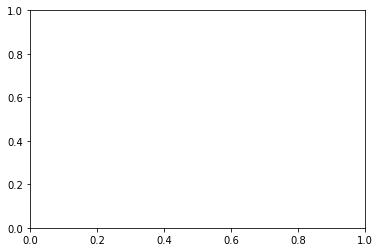

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(n_epochs)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

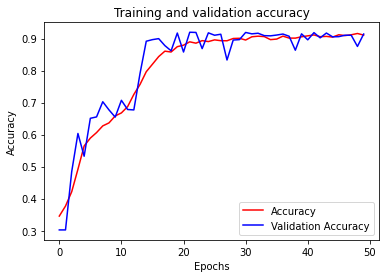

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [ ]:
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.01296
